In [1]:
import pandas as pd
import numpy as np
import joblib
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np

sns.set()

In [2]:
# ----------------------------
# Parameters
# ----------------------------
seq_length = 60

# ----------------------------
# Load processed scaled data
# ----------------------------
scaled_df = pd.read_csv("stocks_datasets/processed_data.csv", index_col=0, parse_dates=True)

# ----------------------------
# Load scaler and model
# ----------------------------
scaler = joblib.load("scaler.save")
model = load_model("lstm_model.keras")
print("✅ LSTM model loaded successfully.")

# ----------------------------
# Prepare last sequence
# ----------------------------
last_sequence = scaled_df['Scaled_Log_Price'][-seq_length:].values  # shape (60,)

last_sequence = np.expand_dims(last_sequence, axis=0)  # shape (1, 60)
last_sequence = np.expand_dims(last_sequence, axis=2)  # shape (1, 60, 1)
last_sequence = last_sequence.astype(np.float32)

# ----------------------------
# Predict next scaled log price
# ----------------------------
next_log_scaled = model.predict(last_sequence)

# ----------------------------
# Invert scaling
# ----------------------------
next_log_price = scaler.inverse_transform(next_log_scaled)
next_price = np.expm1(next_log_price)  # if you used log1p earlier

# ----------------------------
# Get the next date
# ----------------------------
last_date = scaled_df.index[-1]
next_date = pd.bdate_range(start=last_date, periods=2)[1]  # next business day

# ----------------------------
# Create a DataFrame with date as index
# ----------------------------
next_prediction_df = pd.DataFrame(
    data={'Predicted_Price': [next_price[0,0]]},
    index=[next_date]
)

print(next_prediction_df)

✅ LSTM model loaded successfully.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
            Predicted_Price
2025-08-25       325.574677


In [3]:
# ----------------------------
# Parameters
# ----------------------------
seq_length = 60
n_days = 1  # number of steps to predict

# ----------------------------
# Load processed scaled data
# ----------------------------
scaled_df = pd.read_csv("stocks_datasets/processed_data.csv", index_col=0, parse_dates=True)

# ----------------------------
# Load scaler and model
# ----------------------------
scaler = joblib.load("scaler.save")
model = load_model("lstm_model.keras")
print("✅ LSTM model loaded successfully.")

# ----------------------------
# Prepare last sequence
# ----------------------------
last_sequence = scaled_df['Scaled_Log_Price'][-seq_length:].values  # shape (60,)
predictions = []

# ----------------------------
# Predict next n_days
# ----------------------------
for i in range(n_days):
    seq = last_sequence.reshape(1, seq_length, 1).astype(np.float32)

    # Predict scaled log price
    next_log_scaled = model.predict(seq, verbose=0)

    # Invert scaling
    next_log_price = scaler.inverse_transform(next_log_scaled)
    next_price = np.expm1(next_log_price)  # back-transform if log1p was used
    predictions.append(next_price[0, 0])

    # Update sequence with the new prediction
    last_sequence = np.append(last_sequence[1:], next_log_scaled)

# ----------------------------
# Create DataFrame with future dates
# ----------------------------
last_date = scaled_df.index[-1]
future_dates = pd.bdate_range(start=last_date, periods=n_days+1)[1:]

pred_df = pd.DataFrame({'Predicted_Price': predictions}, index=future_dates)

print(pred_df)


✅ LSTM model loaded successfully.
            Predicted_Price
2025-08-25       325.574677


In [4]:
# ----------------------------
# Get the last actual price
# ----------------------------
last_actual_log = scaled_df['Scaled_Log_Price'][-1]  # scaled
last_actual = np.expm1(scaler.inverse_transform([[last_actual_log]]))[0,0]

# ----------------------------
# Combine last actual and next predicted prices
# ----------------------------
comparison_df = pd.DataFrame(
    data={'Price': [last_actual] + predictions},   # predictions from loop
    index=[scaled_df.index[-1]] + list(future_dates)
)

print(comparison_df)

                 Price
2025-08-22  340.010010
2025-08-25  325.574677


C:\Users\spenc\AppData\Local\Temp\ipykernel_12700\3347722586.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  last_actual_log = scaled_df['Scaled_Log_Price'][-1]  # scaled


In [5]:
# ----------------------------
# Get the last N actual prices for visualization
# ----------------------------
# N = 60
# last_prices_log = scaled_df['Scaled_Log_Price'][-N:].values
# last_prices = np.expm1(scaler.inverse_transform(last_prices_log.reshape(-1,1)))

# Get corresponding dates
# dates = scaled_df.index[-N:]

# ----------------------------
# Plot actual prices
# ----------------------------
# plt.figure(figsize=(12,6))
# plt.plot(dates, last_prices, color='blue', label='Actual Price')

# ----------------------------
# Connect last actual price to next predicted price
# ----------------------------
# plt.plot(
  #  [dates[-1], next_date], 
  # [float(last_prices[-1]), float(next_price[0,0])],  # force scalar
  #  color='red', linestyle='--', marker='o', label='Next Prediction'
# )
# Annotate last actual price
# last_price_scalar = last_prices[-1][0]  # extract scalar
# plt.text(dates[-1], last_price_scalar, f"{last_price_scalar:.2f}", 
         # color='blue', fontsize=10, ha='left', va='bottom')

# Annotate next predicted price
# next_price_scalar = float(next_price[0,0])  # already a scalar
# plt.text(next_date, next_price_scalar, f"{next_price_scalar:.2f}", 
         # color='red', fontsize=10, ha='left', va='bottom')
# ----------------------------
# Customize plot
# ----------------------------
# plt.title('Stock Price Prediction')
# plt.xlabel('Date')
# plt.ylabel('Price')
# plt.legend()
# plt.grid(True)
# plt.savefig("plots/COIN_prediction_plot.png", dpi=300, bbox_inches='tight')
# plt.show()

C:\Users\spenc\AppData\Local\Temp\ipykernel_12700\3006127639.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  [float(last_prices[-1]), predictions[0]],


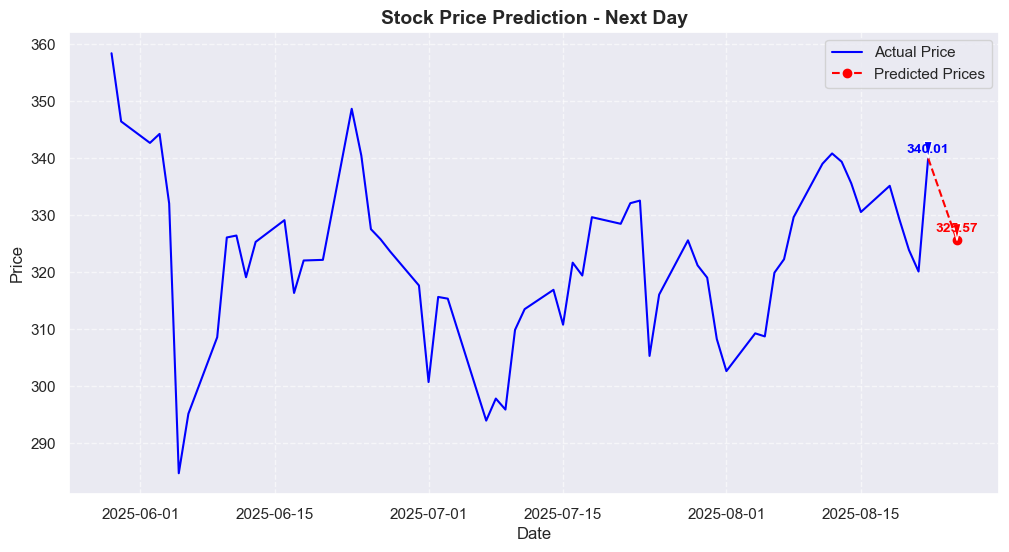

In [6]:
# ----------------------------
# Get the last N actual prices for visualization
# ----------------------------
N = 60
last_prices_log = scaled_df['Scaled_Log_Price'][-N:].values
last_prices = np.expm1(scaler.inverse_transform(last_prices_log.reshape(-1,1)))

# Get corresponding dates
dates = scaled_df.index[-N:]

# ----------------------------
# Plot actual prices
# ----------------------------
plt.figure(figsize=(12,6))
plt.plot(dates, last_prices, color='blue', label='Actual Price')

# ----------------------------
# Plot predicted prices (5 days ahead)
# ----------------------------
plt.plot(future_dates, predictions, color='red', linestyle='--', marker='o', label='Predicted Prices')

# Connect last actual price to the first prediction
plt.plot(
    [dates[-1], future_dates[0]],
    [float(last_prices[-1]), predictions[0]],
    color='red', linestyle='--'
)

# ----------------------------
# Annotate last actual price
# ----------------------------
last_price_scalar = last_prices[-1][0]  # extract scalar

# ----------------------------
# Annotate last actual price
# ----------------------------
plt.annotate(f"{last_price_scalar:.2f}",
             xy=(dates[-1], last_price_scalar),
             xytext=(dates[-1], last_price_scalar + 1.0),
             arrowprops=dict(facecolor='blue', shrink=0.05, width=1, headwidth=6),
             color='blue', fontsize=10, ha='center', weight='bold')

first_date = future_dates[0]
first_price = predictions[0]

plt.annotate(f"{first_price:.2f}",
             xy=(first_date, first_price),
             xytext=(first_date, first_price + 1.5),
             arrowprops=dict(facecolor='red', shrink=0.05, width=1, headwidth=6),
             color='red', fontsize=10, ha='center', weight='bold')

# ----------------------------
# Annotate only the final predicted price
# ----------------------------
#final_date = future_dates[-1]
# final_price = predictions[-1]

# plt.annotate(f"{final_price:.2f}",
 #            xy=(final_date, final_price),
 #            xytext=(final_date, final_price + 1.5),
 #           arrowprops=dict(facecolor='red', shrink=0.05, width=1, headwidth=6),
  #           color='red', fontsize=10, ha='center', weight='bold')

# ----------------------------
# Customize plot
# ----------------------------
plt.title('Stock Price Prediction - Next Day', fontsize=14, weight='bold')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.savefig("plots/TSLA_prediction_plot.png", dpi=300, bbox_inches='tight')
plt.show()